In [104]:
import json
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from tqdm.auto import tqdm
sns.set_style("whitegrid")

In [105]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
1

1

In [6]:
!ls

967.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


README.md                       exact_thresh_by_qid.json
data.json                       f1_thresh_by_qid.json
data_updated.json               hello.py
data_updated_500.json           nb_experiments.ipynb
db                              pred.json
df_questions_all.csv            pred_2.json
df_questions_not_impossible.csv pred_500.json
eval.json                       pred_500_fixed_no_answer.json
eval_2.json                     pyproject.toml
eval_500.json                   uv.lock
evaluation.py


In [7]:
filename = "data.json"
with open(filename, "rb") as f:
    dataset = json.load(f)

In [8]:
dataset.keys()

dict_keys(['version', 'data'])

In [9]:
dataset["version"]

'v2.0'

In [10]:
len(dataset["data"])

35

In [11]:
data = dataset["data"]

In [12]:
type(data)

list

In [13]:
data[0]["paragraphs"][0]

{'qas': [{'question': 'In what country is Normandy located?',
   'id': '56ddde6b9a695914005b9628',
   'answers': [{'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159}],
   'is_impossible': False},
  {'question': 'When were the Normans in Normandy?',
   'id': '56ddde6b9a695914005b9629',
   'answers': [{'text': '10th and 11th centuries', 'answer_start': 94},
    {'text': 'in the 10th and 11th centuries', 'answer_start': 87},
    {'text': '10th and 11th centuries', 'answer_start': 94},
    {'text': '10th and 11th centuries', 'answer_start': 94}],
   'is_impossible': False},
  {'question': 'From which countries did the Norse originate?',
   'id': '56ddde6b9a695914005b962a',
   'answers': [{'text': 'Denmark, Iceland and Norway', 'answer_start': 256},
    {'text': 'Denmark, Iceland and Norway', 'answer_start': 256},
    {'text': 'Denmark, Iceland and Norway', 'answer_star

#Json structure:
data = {"version": "x", 
         "data": [{"title": "...", 
                   "paragraphs": [
                       "qas": [{"question": "...", 
                                "id": "", 
                                "answers"}], # note in case of is_impossible = True, we have plausible answers?
                       "is_impossible": True, 
                       "context": "..."
                   ]}] 
   }

In [14]:
df_all_data = pd.DataFrame()

for list_idx, list_item in enumerate(data):
    title = list_item["title"]
    #print(title)
    
    paragraphs = list_item["paragraphs"]
    
    #print(paragraphs)
    
    for p_idx, paragraph in enumerate(paragraphs):
        paragraph_res = []
        
        context = paragraph["context"]

        for q_idx, qas in enumerate(paragraph["qas"]):
            question = qas["question"]
            is_impossible = qas["is_impossible"]
            answers = qas["answers"]
            question_id = qas["id"]
            
            # TODO: add plausible answers
            res = {"question": question, 
                   "list_idx": list_idx,
                   "paragraph_idx": p_idx,
                   "question_idx": q_idx,
                   "id": question_id, 
                   "is_impossible": is_impossible,
                   "answer_0": np.nan,
                   "answer_1": np.nan,
                   "answer_2": np.nan,
                   "answer_3": np.nan
            }
            
            if len(answers) > 0: 
                for idx, answer in enumerate(answers): 
                    #print(idx)
                    res[f"answer_{idx}"] = answer["text"]
                
            paragraph_res.append(res)

        paragraph_df = pd.DataFrame(paragraph_res)
        paragraph_df["context"] = context
        paragraph_df["title"] = title
        
        df_all_data = pd.concat([df_all_data, paragraph_df], ignore_index=True)
    

In [15]:
df_all_data.head()

,question,list_idx,paragraph_idx,question_idx,id,is_impossible,answer_0,answer_1,answer_2,answer_3,context,title,answer_4,answer_5
0,In what country is Normandy located?,0,0,0,56ddde6b9a695914005b9628,False,France,France,France,France,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
1,When were the Normans in Normandy?,0,0,1,56ddde6b9a695914005b9629,False,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
2,From which countries did the Norse originate?,0,0,2,56ddde6b9a695914005b962a,False,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway",The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
3,Who was the Norse leader?,0,0,3,56ddde6b9a695914005b962b,False,Rollo,Rollo,Rollo,Rollo,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
4,What century did the Normans first gain their ...,0,0,4,56ddde6b9a695914005b962c,False,10th century,the first half of the 10th century,10th,10th,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN


In [16]:
df_all_data.shape

(11873, 14)

In [17]:
len(df_all_data.title.unique())

35

In [18]:
len(df_all_data.context.unique())

1204

In [19]:
df_all_data.is_impossible.value_counts()

is_impossible
True     5945
False    5928
Name: count, dtype: int64

In [20]:
# focus on the possible ones for now 

In [21]:
df_selected = df_all_data.copy()#df_all_data[~df_all_data.is_impossible].copy()

print(df_selected.shape)

(11873, 14)


In [22]:
# some rough statistics for the context length 
df_selected.loc[:, "context_chars"] = df_selected["context"].apply(lambda x: len(x))
df_selected.loc[:, "context_words"] = df_selected.loc[:, "context"].apply(lambda x: len(x.split(" ")))

In [23]:
df_selected.head()

,question,list_idx,paragraph_idx,question_idx,id,is_impossible,answer_0,answer_1,answer_2,answer_3,context,title,answer_4,answer_5,context_chars,context_words
0,In what country is Normandy located?,0,0,0,56ddde6b9a695914005b9628,False,France,France,France,France,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
1,When were the Normans in Normandy?,0,0,1,56ddde6b9a695914005b9629,False,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
2,From which countries did the Norse originate?,0,0,2,56ddde6b9a695914005b962a,False,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway",The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
3,Who was the Norse leader?,0,0,3,56ddde6b9a695914005b962b,False,Rollo,Rollo,Rollo,Rollo,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
4,What century did the Normans first gain their ...,0,0,4,56ddde6b9a695914005b962c,False,10th century,the first half of the 10th century,10th,10th,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113


<Axes: xlabel='context_chars', ylabel='Count'>

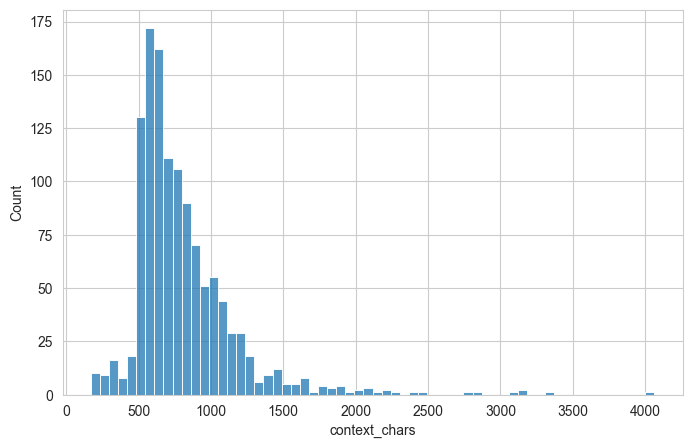

In [24]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_chars"])

<Axes: xlabel='context_words', ylabel='Count'>

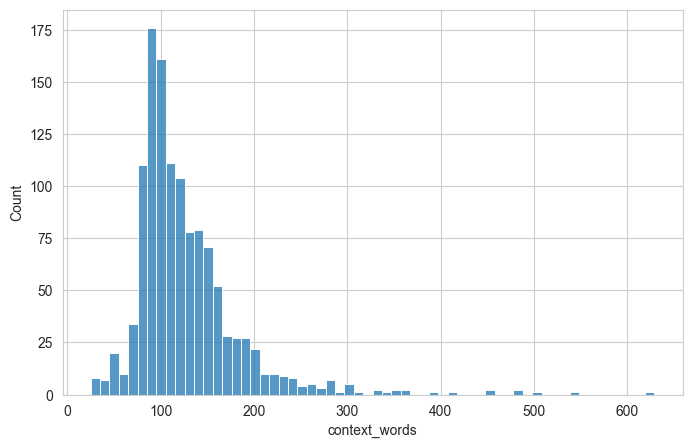

In [25]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_words"])

In [ ]:
df_all_data.to_csv("df_questions_all.csv", index=False)

In [ ]:
df_selected.to_csv("df_questions_not_impossible.csv", index=False)

# Build the RAG architecture

Steps:

**Data Indexing**

Converting text data into a searchable database of vector embeddings, which represent the meaning of the text in a format that computers can easily understand.
- **Documents Chunking**: The collection of documents is split into smaller chunks of text. This allows for more precise and relevant pieces of information to be fed into the language model when needed, avoiding information overload.
- **Vector Embeddings**: The chunks of text are then transformed into vector embeddings. These embeddings encode the meaning of natural language text into numerical representations.
- **Vector Database**: Finally, the vector embeddings are stored in a vector database, making them easily searchable.

**Documents -> Text chunks -> Vector Embeddings -> Vector DB**

**Load -> Split -> Embed -> Store**

In [26]:
from typing import Optional, List, Tuple
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [27]:
langchain_docs = []

for i, row in df_selected.drop_duplicates(subset="context").iterrows():
    context = row.context
    title = row.title
    if i == 0:
        print(context)
        print(title)
    document = LangchainDocument(
        page_content=context,
        metadata={"title": title})

    langchain_docs.append(document)

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Normans


In [28]:
len(langchain_docs)

1204

In [ ]:
langchain_docs[0]

Document(metadata={'title': 'Normans'}, page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.')

In [ ]:
langchain_docs[1]

Document(metadata={'title': 'Normans'}, page_content='The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy into which they assimilated. They adopted the Gallo-Romance language of the Frankish land they settled, their dialect becoming known as Norman, Normaund or Norman French, an important literary language. The Duchy of Normandy, which they formed by treaty with the French crown, was a great fief of medieval France, and under Richard I of Normandy was forged into a cohesive and formidable principality in feudal tenure. The Normans are noted both for their culture, such as their unique Romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. Norman adventurers founded the Kingdom of Sicily under Roger II after conquering southern Italy

### Chunking

In [86]:
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    #tokenizer_name: str,
    ) -> List[LangchainDocument]:

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 15),
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )
    
    docs_processed = []
    
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    """
    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)"""

    return docs_processed 

In [71]:
docs_processed = split_documents(200, langchain_docs)

In [85]:
print(docs_processed[11].page_content)

. Norman adventurers founded the Kingdom of Sicily under Roger II after conquering southern Italy on the Saracens and Byzantines, and an expedition on behalf of their duke, William the Conqueror, led


In [ ]:
print()

len(docs_processed)

docs_processed[2]

### Embeddings & Vector DB

In [125]:
def create_vector_store(docs, embeddings, store_name, db_dir, chunk_size=200):
    
    docs_processed = split_documents(chunk_size, docs)

    persistent_directory = os.path.join(db_dir, store_name)
    
    if not os.path.exists(persistent_directory):
        print(f"\n--- Creating vector store {store_name} ---")
        Chroma.from_documents(
            docs_processed, embeddings, persist_directory=persistent_directory)
        print(f"--- Finished creating vector store {store_name} ---")
    else:
        print(
            f"Vector store {store_name} already exists. No need to initialize.")

In [32]:
current_dir = !pwd

In [33]:
current_dir

['/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments']

In [35]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

In [ ]:
openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key="")


create_vector_store(langchain_docs, openai_embeddings, "chroma_db_openai", db_dir, chunk_size=200)
#create_vector_store(docs_processed, huggingface_embeddings, "chroma_db_huggingface", db_dir)

Vector store chroma_db_openai already exists. No need to initialize.


In [126]:
def query_vector_store(store_name, query, embedding_function, db_dir, k=3):
    persistent_directory = os.path.join(db_dir, store_name)

    relevant_docs = []
    
    if os.path.exists(persistent_directory):
        db = Chroma(
            persist_directory=persistent_directory,
            embedding_function=embedding_function,
        )
        retriever = db.as_retriever(
            search_type="similarity_score_threshold",
            search_kwargs={"k": k, "score_threshold": 0.1},
        )
        relevant_docs = retriever.invoke(query)
        
        # Display the relevant results with metadata
        #print(f"\n--- Relevant Documents for {store_name} ---")
        #for i, doc in enumerate(relevant_docs, 1):
         #   print(f"Document {i}:\n{doc.page_content}\n")

    else:
        print(f"Vector store {store_name} does not exist.")

    return relevant_docs

In [38]:
query = "How is the weather today in Milan"

# Query each vector store
relevant_docs = query_vector_store("chroma_db_openai", query, openai_embeddings, db_dir)
relevant_docs

/var/folders/pc/6l_3sl_n1k55rpgz6bh80h080000gn/T/ipykernel_4727/128558175.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


[Document(metadata={'start_index': 363, 'title': 'Computational_complexity_theory'}, page_content='of the problem, such as asking for a round trip through all sites in Milan whose total length is at most 10 km'),
 Document(metadata={'start_index': 0, 'title': 'Jacksonville,_Florida'}, page_content='Mean monthly temperatures range from around 53 F in January to 82 F in July. High temperatures average 64 to 92 °F (18 to 33 °C) throughout the year'),
 Document(metadata={'start_index': 473, 'title': 'Jacksonville,_Florida'}, page_content='. Summers can be hot and wet, and summer thunderstorms with torrential but brief downpours are common.')]

# Use LLM with retrieved content 

filename = "data.json"
with open(filename, "rb") as f:
    dataset = json.load(f)

questions

In [ ]:
# check this for eval guidelines: 
# https://worksheets.codalab.org/worksheets/0x8212d84ca41c4150b555a075b19ccc05/
# https://rajpurkar.github.io/SQuAD-explorer/

In [127]:
from openai import OpenAI
from langchain_community.embeddings import VoyageEmbeddings
from sentence_transformers import SentenceTransformer

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def save_chatbot_preds(df, 
                       docs, 
                       embeddings,
                       embeddings_name="text-embedding-ada-002", 
                       model_name="gpt-3.5-turbo",
                       chunk_size=200, 
                       num_context_documents=3,
                       filename="pred_500.json"):

    df_to_test = df.copy()
    
    cwd = os.getcwd()
    db_dir = os.path.join(cwd, f"db_{chunk_size}_{embeddings_name}")

    create_vector_store(docs, embeddings, "chroma_db_openai", db_dir, chunk_size=chunk_size)

    answers = []
    contexts = []

    for question in tqdm(df_to_test.question):

        relevant_docs = query_vector_store("chroma_db_openai", query, embeddings, db_dir, k=num_context_documents)

        # Concatenate all relevant documents with numbering
        context = "\n\n".join([f"Source {i+1}: {doc.page_content}" for i, doc in enumerate(relevant_docs)])

        # Create improved structured prompt
        prompt = f"""
        You are a highly accurate and reliable assistant. Answer the user's question using **only** the provided context. 
        If the answer is not in the context, return an empty response (**""**) without making up information.

        Context:
        {context}

        Instructions:
        - Answer concisely and precisely.
        - If the answer is explicitly stated in the context, extract it as-is.
        - If the answer is not in the context, return **""** (empty string).
        - Do **not** infer, assume, or add external information.

        Example:
            **Question:** What is the capital of Italy?
            **Answer:** Rome

        Question: {question}
        Answer (just the answer, no extra words, or "" if unknown):
        """

        # Get response from OpenAI
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": question}
            ]
        )
        
        answer = response.choices[0].message.content
        
    # reference = context[0]  # Using first context as reference
    # the reference is the GT?

        answers.append(answer)
        contexts.append(context)
  
    preds = dict(zip(df_to_test["id"], answers))

    with open(filename, "w") as f:
        json.dump(preds, f, indent=4, sort_keys=True)


In [50]:
df_to_test = pd.read_csv("df_questions_all.csv")
df_to_test = df_to_test[0:500]
df_to_test.columns

Index(['question', 'list_idx', 'paragraph_idx', 'question_idx', 'id',
       'is_impossible', 'answer_0', 'answer_1', 'answer_2', 'answer_3',
       'context', 'title', 'answer_4', 'answer_5'],
      dtype='object')


save_chatbot_preds(df_to_test, langchain_docs, openai_embeddings, model_name="gpt-3.5-turbo", chunk_size=200, filename="pred_500_fixed_no_answer.json")

Comments
Peak distribution for number of characters in the documents is ~600 words. 
- smaller chunks: reduced noise from irrelevant content - works well with dense embeddings*
- larger chunks: preserves context better; ideal if queries require full document context, works well with hybrid search*

TEXT CHUNKING 

1. CHARACTER SPLITTING : divide the text into N-character sized chunks. Can split words in the middle. 
2. RECURSIVE CHARACTER SPLITTING: preserves sentences. Avoids splitting sentences midword (note that RecursiveCharacterTextSplitter with separator does exactly that). Split the
document where a double new line is present, then, if the chunk size is still exceeded, split at new lines, and so on.
3. SEMANTIC SPLITTING: keeps related content together. Use embeddings to split based on meaning.
+ other techniques

EMBEDDINGS 
Create fixed-length vector representation of text, focusing on semanting meaning for tasks like similarity comparison. 
Most up to date embedding models, both proprietary and open source, with performance metrics across different tasks: https://huggingface.co/spaces/mteb/leaderboard 
This contains also a "retrieval" column with performance metrics. Click on the column to sort the models.
Interesting article: https://www.mongodb.com/developer/products/atlas/choose-embedding-model-rag/


In [ ]:
# TODO: try different text splitters
# TODO: improve num of documents retrieved and the retrieval threshold 

#chunk_sizes = [100, 200, 300, 400, 500, 800, 1200, 1600]
chunk_sizes =  [100] #[600, 800]

models = ["gpt-3.5-turbo"]
embeddings_names = [#"text-embedding-ada-002", # poor performance OpenAI
                    "text-embedding-3-small" # OpenAI
                    # "text-embedding-3-large" # OpenAI
                 #   "voyageai/voyage-3-m-exp" # HuggingFace - best retrieval model mar 2025 based on HuggingFace MTEB leaderboard
                  # "Snowflake/snowflake-arctic-embed-l-v2.0" # ranked 6th, 568M params
                 ]

                    
embeddings_platform = "OpenAI"    
    
for embeddings_name in embeddings_names: 
    
    if embeddings_platform == "OpenAI": 
        embeddings = OpenAIEmbeddings(model=embeddings_name, openai_api_key="")
    elif embeddings_platform == "HuggingFace":
        embeddings = HuggingFaceEmbeddings(
         model_name=embeddings_name, show_progress=True 
    )
    
    # only paid?
    elif embeddings_platform == "custom":
        cache_dir = './model_cache'
        #embeddings = VoyageEmbeddings(voyage_api_key="", model="voyage-3")
       # embeddings = SentenceTransformer("Linq-AI-Research/Linq-Embed-Mistral") # heavy 7B parameters  
        embeddings = SentenceTransformer("Snowflake/snowflake-arctic-embed-l-v2.0", cache_folder=cache_dir) 
    else:
        print("Embeddings error")
       
    for model_name in models: 
        for chunk_size in chunk_sizes:
            save_chatbot_preds(
                df_to_test,
                langchain_docs,
                embeddings, 
                embeddings_name=embeddings_name,
                model_name=model_name, 
                chunk_size=chunk_size, 
                num_context_documents=3,
                filename=f"pred_500_fixed_no_answer_{chunk_size}_{model_name}_{embeddings_name}.json"
            ) 


--- Creating vector store chroma_db_openai ---


AttributeError: 'SentenceTransformer' object has no attribute 'embed_documents'

# Evaluation

In [ ]:
df = pd.read_csv("df_questions_all.csv")
df.head()

,question,list_idx,paragraph_idx,question_idx,id,is_impossible,answer_0,answer_1,answer_2,answer_3,context,title,answer_4,answer_5
0,In what country is Normandy located?,0,0,0,56ddde6b9a695914005b9628,False,France,France,France,France,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
1,When were the Normans in Normandy?,0,0,1,56ddde6b9a695914005b9629,False,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
2,From which countries did the Norse originate?,0,0,2,56ddde6b9a695914005b962a,False,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway",The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
3,Who was the Norse leader?,0,0,3,56ddde6b9a695914005b962b,False,Rollo,Rollo,Rollo,Rollo,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
4,What century did the Normans first gain their ...,0,0,4,56ddde6b9a695914005b962c,False,10th century,the first half of the 10th century,10th,10th,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN


In [ ]:
print(len(df))
df_sel = df[df["id"].isin(qids)]
print(len(df_sel))

11873
500


In [ ]:
all_res = {"version": "v2.0", "data": []}

all_res_list = []

for list_idx in set(df_sel.list_idx):
    print(list_idx)

    df_idx = df_sel[df_sel.list_idx == list_idx]

    title = df_idx.title.iloc[0]

    print("title", title)

    paragraphs = []
    
    list_res = {"title": title, 
                "paragraphs": paragraphs}
    
    paragraphs_idx = set(df_idx.paragraph_idx)
    
    print(paragraphs_idx)

    paragraphs_res = []

    for p_idx in paragraphs_idx:
        paragraph_df = df_idx[df_idx.paragraph_idx == p_idx]

        context = paragraph_df.context.iloc[0]

        paragraph_res = {"context": context, "qas": []}

        questions_df = paragraph_df[paragraph_df["id"].isin(qids)]

        if not questions_df.empty:
            question_idx = set(questions_df.question_idx)

            questions_list = []
        
            for q_idx in question_idx:
                question_df = questions_df[questions_df.question_idx == q_idx]

                question = question_df.question.iloc[0]
                question_id = question_df["id"].iloc[0]
                is_impossible = question_df.is_impossible.iloc[0]

                answers = []

                for i in range(0,3):
                    answer = question_df[f"answer_{i}"].iloc[0]

                    if answer == answer:
                    
                        answers.append({"text": answer})
                
                if is_impossible:
                    impossible_str = "true"
                else:
                    impossible_str = "false"
                
                question_res = {"question": question,  
                                "id": question_id,
                                "answers": answers,
                                "is_impossible": impossible_str
                               }
                
                questions_list.append(question_res)

            paragraph_res["qas"] = questions_list
                
        
        paragraphs.append(paragraph_res)

    all_res_list.append(list_res)
        
    

0
title Normans
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}
1
title Computational_complexity_theory
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [ ]:
all_res["data"] = all_res_list

In [ ]:
with open("data_updated_500.json", "w") as f:
    json.dump(all_res, f)

# Inspect the eval results 

In [ ]:
import json
import pandas as pd 


filename = "f1_thresh_by_qid.json"
with open(filename, "rb") as f:
    f1_scores = json.load(f)
    
df_scores = pd.DataFrame.from_dict(f1_scores, orient="index", columns=["f1_score"])
df_scores.index.name = "id"
df_scores.reset_index(inplace=True, drop=False)
df_scores.head()

,id,f1_score
0,56ddde6b9a695914005b9628,0.333333
1,56ddde6b9a695914005b9629,0.571429
2,56ddde6b9a695914005b962a,0.461538
3,56ddde6b9a695914005b962b,0.000000
4,56ddde6b9a695914005b962c,0.428571


In [ ]:
filename = "exact_thresh_by_qid.json"
with open(filename, "rb") as f:
    exact_scores = json.load(f)
    
df_scores_exact = pd.DataFrame.from_dict(exact_scores, orient="index", columns=["exact_score"])
df_scores_exact.index.name = "id"
df_scores_exact.reset_index(inplace=True, drop=False)
df_scores_exact.head()

,id,exact_score
0,56ddde6b9a695914005b9628,0
1,56ddde6b9a695914005b9629,0
2,56ddde6b9a695914005b962a,0
3,56ddde6b9a695914005b962b,0
4,56ddde6b9a695914005b962c,0


In [ ]:

filename = "pred.json"
with open(filename, "rb") as f:
    pred = json.load(f)
    
df_pred = pd.DataFrame.from_dict(pred, orient="index", columns=["pred"])
df_pred.index.name = "id"
df_pred.reset_index(inplace=True, drop=False)
df_pred.head()

,id,pred
0,56ddde6b9a695914005b9628,Normandy is located in France.
1,56ddde6b9a695914005b9629,The Normans were in Normandy from the 10th to ...
2,56ddde6b9a695914005b962a,The Norse people originated from modern-day De...
3,56ddde6b9a695914005b962b,"I'm sorry, but I can't provide an accurate ans..."
4,56ddde6b9a695914005b962c,The Normans first gained their separate identi...


In [ ]:
df = pd.read_csv("df_questions_all.csv")
df = df.merge(df_scores, how="left", on="id")
df = df.merge(df_scores_exact, how="left", on="id")
df = df.merge(df_pred, how="left", on="id")


In [ ]:
df[["id", "question", "f1_score", "exact_score", "answer_0", "answer_1", "answer_3", "pred"]].head()

,id,question,f1_score,exact_score,answer_0,answer_1,answer_3,pred
0,56ddde6b9a695914005b9628,In what country is Normandy located?,0.333333,0.0,France,France,France,Normandy is located in France.
1,56ddde6b9a695914005b9629,When were the Normans in Normandy?,0.571429,0.0,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,The Normans were in Normandy from the 10th to ...
2,56ddde6b9a695914005b962a,From which countries did the Norse originate?,0.461538,0.0,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway",The Norse people originated from modern-day De...
3,56ddde6b9a695914005b962b,Who was the Norse leader?,0.000000,0.0,Rollo,Rollo,Rollo,"I'm sorry, but I can't provide an accurate ans..."
4,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,0.428571,0.0,10th century,the first half of the 10th century,10th,The Normans first gained their separate identi...


In [ ]:
df[df.exact_score > 0][["question", "pred", "answer_0", "answer_1", "answer_2", "f1_score", "exact_score"]]

,question,pred,answer_0,answer_1,answer_2,f1_score,exact_score
95,Where did Harold II die?,Battle of Hastings,Battle of Hastings,the Battle of Hastings,at the Battle of Hastings,1.0,1.0
97,When was the Battle of Hastings?,1066.,1066,In 1066,1066,1.0,1.0


In [ ]:
df.sort_values(by="f1_score", ascending=False)[["question", "pred", "answer_0", "answer_1", "answer_2", "f1_score", "exact_score"]].head()

,question,pred,answer_0,answer_1,answer_2,f1_score,exact_score
97,When was the Battle of Hastings?,1066.,1066,In 1066,1066,1.000000,1.0
95,Where did Harold II die?,Battle of Hastings,Battle of Hastings,the Battle of Hastings,at the Battle of Hastings,1.000000,1.0
1,When were the Normans in Normandy?,The Normans were in Normandy from the 10th to ...,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,0.571429,0.0
2,From which countries did the Norse originate?,The Norse people originated from modern-day De...,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway",0.461538,0.0
4,What century did the Normans first gain their ...,The Normans first gained their separate identi...,10th century,the first half of the 10th century,10th,0.428571,0.0


In [ ]:
# Note that this is a good answer but the f1 score is low because the model wraps the information 
# in a phrase -> these words are used to compute the f1 score 
df.loc[4]["pred"]

'The Normans first gained their separate identity in the 10th century.'

In [ ]:
f1_scores

{'56ddde6b9a695914005b9628': 0.33333333333333337,
 '56ddde6b9a695914005b9629': 0.5714285714285714,
 '56ddde6b9a695914005b962a': 0.46153846153846156,
 '56ddde6b9a695914005b962b': 0,
 '56ddde6b9a695914005b962c': 0.42857142857142855,
 '5ad39d53604f3c001a3fe8d1': 0,
 '5ad39d53604f3c001a3fe8d2': 0,
 '5ad39d53604f3c001a3fe8d3': 0,
 '5ad39d53604f3c001a3fe8d4': 0,
 '56dddf4066d3e219004dad5f': 0.4,
 '56dddf4066d3e219004dad60': 0,
 '56dddf4066d3e219004dad61': 0,
 '5ad3a266604f3c001a3fea27': 0,
 '5ad3a266604f3c001a3fea28': 0,
 '5ad3a266604f3c001a3fea29': 0,
 '5ad3a266604f3c001a3fea2a': 0,
 '5ad3a266604f3c001a3fea2b': 0,
 '56dde0379a695914005b9636': 0.07999999999999999,
 '56dde0379a695914005b9637': 0.15384615384615385,
 '5ad3ab70604f3c001a3feb89': 0,
 '5ad3ab70604f3c001a3feb8a': 0,
 '56dde0ba66d3e219004dad75': 0.25,
 '56dde0ba66d3e219004dad76': 0.28571428571428575,
 '56dde0ba66d3e219004dad77': 0,
 '5ad3ad61604f3c001a3fec0d': 0,
 '5ad3ad61604f3c001a3fec0e': 0,
 '5ad3ad61604f3c001a3fec0f': 0,
 '5ad3